PyTorch Version:  1.3.1
Torchvision Version:  0.4.2

Batch Size: 16
learning_rate: 0.001
momentum: 0.95
num_epochs: 50
ith_batch_display: 625

Epoch 0/49
----------
train Batch: 0 of 3750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Batch: 625 of 3750
train Batch: 1250 of 3750
train Batch: 1875 of 3750
train Batch: 2500 of 3750
train Batch: 3125 of 3750
train Loss: 2.1937 Acc: 0.2577
test Batch: 0 of 625
test Loss: 1.8417 Acc: 0.6198

Epoch 1/49
----------
train Batch: 0 of 3750
train Batch: 625 of 3750
train Batch: 1250 of 3750
train Batch: 1875 of 3750
train Batch: 2500 of 3750
train Batch: 3125 of 3750
train Loss: 1.7873 Acc: 0.6755
test Batch: 0 of 625
test Loss: 1.7500 Acc: 0.7126

Epoch 2/49
----------
train Batch: 0 of 3750
train Batch: 625 of 3750
train Batch: 1250 of 3750
train Batch: 1875 of 3750
train Batch: 2500 of 3750
train Batch: 3125 of 3750
train Loss: 1.7541 Acc: 0.7077
test Batch: 0 of 625
test Loss: 1.7459 Acc: 0.7148

Epoch 3/49
----------
train Batch: 0 of 3750
train Batch: 625 of 3750
train Batch: 1250 of 3750
train Batch: 1875 of 3750
train Batch: 2500 of 3750
train Batch: 3125 of 3750
train Loss: 1.7379 Acc: 0.7241
test Batch: 0 of 625
test Loss: 1.7319 Acc: 0.7289

Epoch 4/49
------

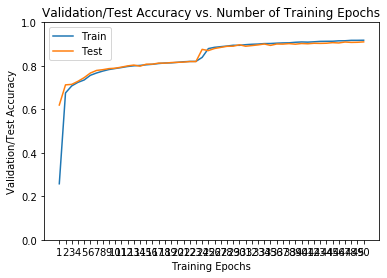

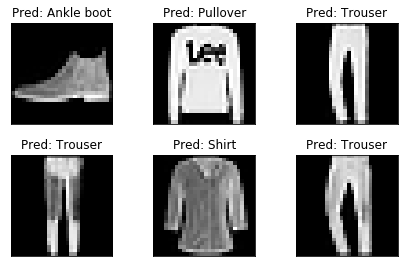

In [2]:
# source code inspireed by
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)



root = './data'

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

train_set = datasets.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_set = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)


# hyperparameter
# TODO Find good hyperparameters
batch_size = 16
learning_rate = 0.001
momentum = 0.95
num_epochs = 50
ith_batch_display = 10000//batch_size

print()
print("Batch Size:", batch_size)
print("learning_rate:", learning_rate)
print("momentum:", momentum)
print("num_epochs:", num_epochs)
print("ith_batch_display:", ith_batch_display)
print()


# Load train and test data
data_loaders = {}
data_loaders['train'] = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
data_loaders['test'] = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

# implement your own NNs
    
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        # TODO YOUR CODE HERE
        self.n_img = 28*28
        self.kernel_size = 3
        self.n_ch0 = 1
        self.n_ch1 = 32
        self.n_ch2 = 32
        self.n_ch3 = 64
        self.n_ch4 = 64
        self.n_h1 = 512
        self.n_h2 = 10
        self.mp_win_size = 2
        self.mp_stride = 2
        self.p = 0.25
        self.conv1 = nn.Conv2d(self.n_ch0, self.n_ch1, self.kernel_size)
        self.conv2 = nn.Conv2d(self.n_ch1, self.n_ch2, self.kernel_size)
        self.maxpool = nn.MaxPool2d(self.mp_win_size, self.mp_stride)
        self.dropout = nn.Dropout(self.p)
        self.conv3 = nn.Conv2d(self.n_ch2, self.n_ch3, self.kernel_size)
        self.conv4 = nn.Conv2d(self.n_ch3, self.n_ch4, self.kernel_size)
        self.fc1 = nn.Linear(1024 , self.n_h1) 
        self.fc2 = nn.Linear(self.n_h1 , self.n_h2)
    def forward(self, x):
        # TODO YOUR CODE HERE
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = x.view(-1, self.num_flat_features(x)) # flatten? 
        x = F.relu(self.fc1(x)) 
        x = F.softmax(self.fc2(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def name(self):
        return "MyNeuralNetwork"



## training
# model = MyNeuralNetwork()

# gpu setup
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyNeuralNetwork().to(device)


optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []


best_acc = 0.0
since = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(data_loaders[phase]):
            # ADDON for gpu
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()


            
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # ADDON for gpu
                outputs = model(inputs)
                # outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if batch_idx % ith_batch_display == 0:
                print('{} Batch: {} of {}'.format(phase, batch_idx, len(data_loaders[phase])))

        epoch_loss = running_loss / len(data_loaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(data_loaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'test':
            test_acc_history.append(epoch_acc)
            test_loss_history.append(epoch_loss)
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_loss_history.append(epoch_loss)

    print()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

acc_train_hist = []
acc_test_hist = []

acc_train_hist = [h.cpu().numpy() for h in train_acc_history]
acc_test_hist = [h.cpu().numpy() for h in test_acc_history]

plt.title("Validation/Test Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation/Test Accuracy")
plt.plot(range(1,num_epochs+1),acc_train_hist,label="Train")
plt.plot(range(1,num_epochs+1),acc_test_hist,label="Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()



examples = enumerate(data_loaders['test'])
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model.cpu()(example_data)

categories = {
    0:	'T-shirt/top',
    1:	'Trouser',
    2:	'Pullover',
    3:	'Dress',
    4:	'Coat',
    5:	'Sandal',
    6:	'Shirt',
    7:	'Sneaker',
    8:	'Bag',
    9:	'Ankle boot'
}

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Pred: {}".format(
      categories[output.data.max(1, keepdim=True)[1][i].item()]))
    plt.xticks([])
    plt.yticks([])
plt.show()



In [0]:
# 6 Epochs with SGD Optimizer: 81.23 in 3:53 min
# 6 Epochs with Adam Optimizer: 79.9  in 4:09 min
# 15 Epochs with SGD Optimizer: 80.3 in 3:37 min
